# Importation

In [26]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
random_state = 42

In [3]:
housing = fetch_california_housing(as_frame=True)
# Prepare the data
X = housing.data
y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

## Diagnostiquer la multicolinéarité

In [18]:
scaler = StandardScaler(with_mean=False, with_std=True)
scaler.fit(X)
X_scaled = scaler.transform(X)

In [19]:
n,p = X.shape
pca = PCA(n_components=p)
pca.fit(X_scaled)
pca.explained_variance_

array([2.02704763, 1.88139074, 1.27115235, 1.03108764, 1.0031042 ,
       0.65941198, 0.08160574, 0.04558733])

In [20]:
pca.explained_variance_ratio_

array([0.25336868, 0.23516245, 0.15888635, 0.12887971, 0.12538195,
       0.0824225 , 0.01020022, 0.00569814])

Effectivement, les deux dernières valeurs propres sont particulièrement proches de 0 et elles expliquent des quantités négligeables d’information. Multicolinéarité en vue !

# First experiments

In [5]:
res = {
        "model": [],
        "MSE": [],
        "R^2": []
    }
for model_name, model in models.items():
    # Train and evaluate models

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    res["model"].append(model_name)
    res["MSE"].append(mse)
    res["R^2"].append(r2)

pd.DataFrame(res)

,model,MSE,R^2
0,linearmodel,0.555892,0.575788
1,Lasso,0.544449,0.584520
2,Ridge,0.555891,0.575788
3,PLSRegression,0.644844,0.507906
4,PCR,0.555892,0.575788
5,ElasticNet,0.764556,0.416552
6,Decision Tree,0.495235,0.622076
7,Random Forest,0.255368,0.805123
8,Gradient Boosting,0.293997,0.775645


## Sélection stepwise

In [14]:
mod_seq_backwark = SequentialFeatureSelector(
    estimator=LinearRegression(), direction="backward", n_features_to_select="auto"
)
mod_seq_forward = SequentialFeatureSelector(
    estimator=LinearRegression(), direction="forward", n_features_to_select="auto"
)
mod_seqs = { 'backward': mod_seq_backwark, 
'forward': mod_seq_forward
}
for mode, mod_seq in mod_seqs.items():
    X_seq = mod_seq.fit_transform(X, y)
    print(f"{mode} : {X.columns[mod_seq.get_support()].to_list()}")
    model = LinearRegression()
    model.fit(X_seq, y)
    y_pred = model.predict(X_seq)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"MSE: {mse}, R^2: {r2}")


backward : ['MedInc', 'HouseAge', 'Latitude', 'Longitude']
MSE: 0.540576060099744, R^2: 0.5940250548052657
forward : ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms']
MSE: 0.615856645418495, R^2: 0.5374890115824703


In [25]:
pcr = {}
error_test_pcr = {}
error_train_pcr = {}
for n_comp in np.arange(1, p + 1):
    pcr[n_comp] = make_pipeline(StandardScaler(with_mean=False, with_std=True), PCA(n_components=n_comp), LinearRegression())
    cv = cross_validate(pcr[n_comp], X, y, scoring="neg_root_mean_squared_error", return_train_score=True)
    error_test_pcr[n_comp] = -np.mean(cv["test_score"])
    error_train_pcr[n_comp] = -np.mean(cv["train_score"])

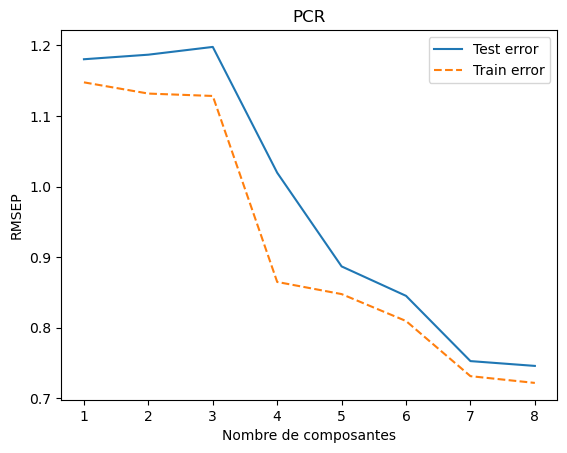

In [27]:
plt.plot(error_test_pcr.keys(), error_test_pcr.values(), label="Test error")
plt.plot(error_train_pcr.keys(), error_train_pcr.values(), ls="--", label="Train error")
plt.xlabel("Nombre de composantes")
plt.ylabel("RMSEP")
plt.title("PCR")
plt.legend()
plt.show()